In [1]:
# Python Version: 3.9

# Requirements
# !pip install pygad
# !pip install numpy

In [2]:
from random import choices, choice, randint, randrange, random
from math import log10
import os
import time
import pygad
import json
import numpy as np

In [3]:
def parse_input(filename: str):
    with open(filename, "r") as f:
        data = f.read()
    data = [i for i in data.split("\n") if i.strip() != ""]
    
    data = data[1:]
    client_data = [[data[i], data[i+1]] for i in range(0, len(data), 2)]
    
    for i in range(len(client_data)):
        likes, dislikes = client_data[i]
        likes = set(likes.split(" ")[1:])
        dislikes = set(dislikes.split(" ")[1:] or [])
        client_data[i] = [likes, dislikes]
    return client_data

In [4]:
def score_pizza(pizza_ingredients: set[str]):
    pizza_ingredients = set(pizza_ingredients)
    score = 0
    global client_data
    for client_info in client_data:
        client_likes, client_dislikes = client_info
        client_likes_pizza = True
        
        # all the ingredients they like are on the pizza
        for liked_ingredient in client_likes:
            if liked_ingredient not in pizza_ingredients:
                client_likes_pizza = False
                break

        # none of the ingredients they dislike are on the pizza 
        if client_likes_pizza:
            for disliked_ingredient in client_dislikes:
                if disliked_ingredient in pizza_ingredients:
                    client_likes_pizza = False
                    break
        if client_likes_pizza:
            score += 1
    return score

In [5]:
def getAllIngredients():
    global client_data
    allIngredients = set()
    for client_info in client_data:
        client_likes, client_dislikes = client_info
        allIngredients = allIngredients.union(client_likes)
        allIngredients = allIngredients.union(client_dislikes)
    return sorted(list(allIngredients))

In [6]:
def genome_to_ingredients(genome: list[int]):
    'Convert genome to what pizza ingredients they represent'
    ingredients = set()
    for idx, bit in enumerate(genome):
        if bit == 1:
            ingredients.add(allIngredients[idx])
    return ingredients

# Fitness Function
# Reason for pop_idx parameter, see here 
# https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html#preparing-the-fitness-func-parameter
def get_genome_score(genome, pop_idx):
    'Get score of genome i.e. how many clients were fine with the pizza'
    ingredients = genome_to_ingredients(genome)
    return score_pizza(ingredients)

In [18]:
files = ['./input/' + file for file in os.listdir('./input')]
input_file = files[0]   # Change index here

client_data = parse_input(input_file)
allIngredients = list(getAllIngredients())
ingredientCount = len(allIngredients)
clientCount = len(client_data)
bestGenome = None
bestScore = 0
plotsArray = []

print(f"File selected: {input_file}")
print(f"No. of ingredients: {ingredientCount} | No. of clients: {clientCount}")
print(f"No. of permutations possible: 2^{ingredientCount} or 10^{round(log10(2)*ingredientCount, 2)}")

parameters = {}

parameters["input_filename"] = input_file
parameters["total_ingredient_count"] = ingredientCount
parameters["client_count"] = clientCount

# Fixed Parameters
parameters["num_gens"]  = ingredientCount

# Parameters
parameters["gen_count"]             = 10_000             # Max no. of generations
parameters["num_parents_mating"]    = 4
parameters["sol_per_pop"]           = 10                 # No. of solutions within the population
parameters["parent_selection_type"] = "random"           # sss, rws, sus, rank, random, tournament
parameters["keep_parents"]          = 1                   
parameters["crossover_type"]        = "uniform"          # single_point, two_points, uniform, scattered
parameters["mutation_type"]         = "inversion"        # random, swap, inversion, scramble, adaptive
parameters["mutation_probability"]  = None
parameters["mutation_percent_genes"]= 10

ga_instance = pygad.GA(
    num_generations=parameters["gen_count"],
    num_parents_mating=parameters["num_parents_mating"],
    fitness_func=get_genome_score,
    sol_per_pop=parameters["sol_per_pop"],
    num_genes=parameters["num_gens"],
    parent_selection_type=parameters["parent_selection_type"],
    keep_parents=parameters["keep_parents"],
    crossover_type=parameters["crossover_type"],
    mutation_type=parameters["mutation_type"],
    mutation_percent_genes=parameters["mutation_percent_genes"],
    mutation_probability=parameters["mutation_probability"],
    gene_space=[0,1],
    gene_type=int
)

File selected: ./input/a_an_example.in.txt
No. of ingredients: 6 | No. of clients: 3
No. of permutations possible: 2^6 or 10^1.81


Time Taken: 3.31 seconds
Best Score: 2


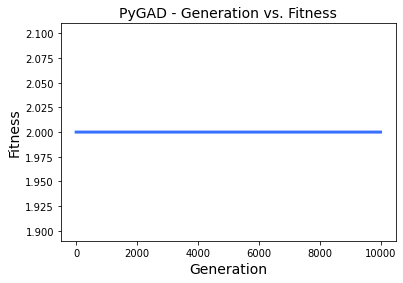

In [19]:
start = time.perf_counter()
ga_instance.run()
solution, solution_fitness, solution_idx = ga_instance.best_solution()
best_score = int(solution_fitness)
time_taken = round(time.perf_counter() - start, 2)
print(f"Time Taken: {time_taken} seconds")
print(f"Best Score: {best_score}")

ingredients_used = genome_to_ingredients(solution)

parameters["best_score"] = best_score
parameters["solution_genome"] = "".join(map(str, solution))
parameters["solution_ingredients"] = f"{len(ingredients_used)} {' '.join(ingredients_used)}"
parameters["time_taken_in_seconds"] = time_taken

# Save the results in results.json
with open("results.json", "r") as f:
    d = json.load(f)
    d.append(parameters)    
with open("results.json", "w") as f:
    d = sorted(d, key=lambda x: -x["best_score"])
    json.dump(d, f, indent=4)

plotsArray.append(ga_instance.plot_fitness())